In [4]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

In [6]:
class DataLoader:
    def __init__(self):
        self.train, self.valid, self.test = self.load_data()

    def load_data(self):
        """Load MNIST train, validation, and test data."""
        # For notebooks, use relative path to parent directory
        data_path = '../mnist.pkl'
        with open(data_path, 'rb') as f:
            train, valid, test = pickle.load(f, encoding='latin-1')
        return train, valid, test
    
    def get_data_information(self):
        """Return the shape of the datasets, their data types, unique labels and data range."""
        return {
            'train': (self.train[0].shape, self.train[1].shape),
            'train_data_type': type(self.train[0]),
            'valid': (self.valid[0].shape, self.valid[1].shape),
            'valid_data_type': type(self.valid[0]),
            'test': (self.test[0].shape, self.test[1].shape),
            'test_data_type': type(self.test[0]),
            'unique_labels': set(self.train[1]),
            'training_data_range': (self.train[0].min(), self.train[0].max())
        }
    
    def get_train_data(self):
        """Return training data and labels."""
        return self.train

    def get_valid_data(self):
        """Return validation data and labels."""
        return self.valid

    def get_test_data(self):
        """Return test data and labels."""
        return self.test
    
    def get_all_data(self):
        """Return all datasets."""
        return self.train, self.valid, self.test
    
    def print_data_summary(self):
        """Print a summary of the datasets."""
        info = self.get_data_information()
        print("Data Summary:")
        print(f"Training set: {info['train'][0]} samples, Labels: {info['train'][1]}")
        print(f"Validation set: {info['valid'][0]} samples, Labels: {info['valid'][1]}")
        print(f"Test set: {info['test'][0]} samples, Labels: {info['test'][1]}")
        print(f"Unique labels in training set: {info['unique_labels']}")
        print(f"Training data range: {info['training_data_range']}")
    
    def draw_sample(self, data, labels, index=None):
        """Draw a sample image from the dataset.
        
        Args:
            data: Image data array (samples, height, width) or (samples, pixels)
            labels: Label array
            index: Index of image to draw (random if None)
        """
        if index is None:
            index = np.random.randint(0, len(data))
        
        image = data[index]
        label = labels[index]
        
        # Reshape if flattened (784 pixels -> 28x28)
        if len(image.shape) == 1:
            image = image.reshape(28, 28)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.show()

# Data example

Data Summary:
Training set: (50000, 784) samples, Labels: (50000,)
Validation set: (10000, 784) samples, Labels: (10000,)
Test set: (10000, 784) samples, Labels: (10000,)
Unique labels in training set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data range: (0.0, 0.99609375)


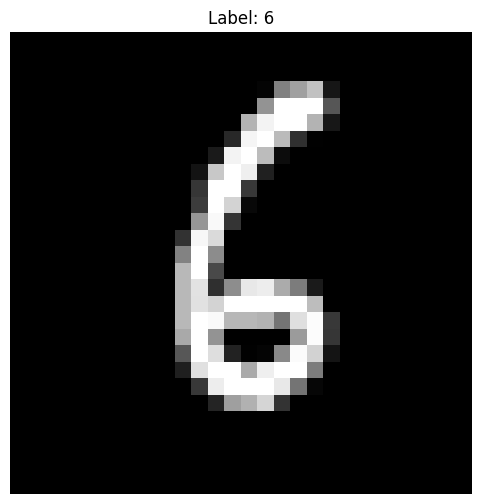

In [7]:
# Test the DataLoader
loader = DataLoader()
loader.print_data_summary()
train_data, train_labels = loader.get_train_data()
loader.draw_sample(train_data, train_labels)

In [ ]:
class Data:
    """Data class for implementing autograd for np.ndarray operations."""

    def __init__(self, values: np.ndarray, parents=None, grad=False):
        self._data = values
        self._backward = lambda: None
        self._grad = grad
        self._num_grad = np.zeros_like(self._data)  # accumulated gradient
        self._parents = parents

    def __str__(self):
        return str(self._data)

    def __repr__(self):
        return f"grad={self._grad} data={str(self)}"

    def _match_shape(grad, shape):
        """Sum grad over broadcasted dims so it matches shape."""
        while len(grad.shape) > len(shape):
            grad = grad.sum(axis=0)
        for i, (g, s) in enumerate(zip(grad.shape, shape)):
            if s == 1 and g > 1:
                grad = grad.sum(axis=i, keepdims=True)
        return grad

    def __add__(self, other):
        if isinstance(other, Data):
            out = Data(self._data + other._data, parents=(self, other))
            def _backward():
                self._num_grad += Data._match_shape(out._num_grad, self._data.shape)
                other._num_grad += Data._match_shape(out._num_grad, other._data.shape)
            out._backward = _backward
            return out
        out = Data(self._data + other, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad, self._data.shape)
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        if isinstance(other, Data):
            out = Data(self._data - other._data, parents=(self, other))
            def _backward():
                self._num_grad += Data._match_shape(out._num_grad, self._data.shape)
                other._num_grad += Data._match_shape(-out._num_grad, other._data.shape)
            out._backward = _backward
            return out
        out = Data(self._data - other, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad, self._data.shape)
        out._backward = _backward
        return out

    def __rsub__(self, other):
        return -self + other

    def __mul__(self, other):
        if isinstance(other, Data):
            out = Data(self._data * other._data, parents=(self, other))
            def _backward():
                self._num_grad += Data._match_shape(out._num_grad * other._data, self._data.shape)
                other._num_grad += Data._match_shape(out._num_grad * self._data, other._data.shape)
            out._backward = _backward
            return out
        out = Data(self._data * other, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad * other, self._data.shape)
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __matmul__(self, other):
        if isinstance(other, Data):
            out = Data(self._data @ other._data, parents=(self, other))
            def _backward():
                self._num_grad += out._num_grad @ other._data.T
                other._num_grad += self._data.T @ out._num_grad
            out._backward = _backward
            return out
        out = Data(self._data @ other, parents=(self,))
        def _backward():
            self._num_grad += out._num_grad @ other.T
        out._backward = _backward
        return out

    def __truediv__(self, other):
        if isinstance(other, Data):
            out = Data(self._data / other._data, parents=(self, other))
            def _backward():
                self._num_grad += Data._match_shape(out._num_grad / other._data, self._data.shape)
                other._num_grad += Data._match_shape(out._num_grad * (-self._data / (other._data ** 2)),
                                                     other._data.shape)
            out._backward = _backward
            return out
        out = Data(self._data / other, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad / other, self._data.shape)
        out._backward = _backward
        return out

    def __rtruediv__(self, other):
        return other * Data(np.array([1.0])) / self

    def __neg__(self):
        out = Data(-self._data, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(-out._num_grad, self._data.shape)
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supports int/float powers"
        out = Data(self._data ** other, parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad * other * self._data ** (other - 1),
                                                self._data.shape)
        out._backward = _backward
        return out

    # --- activations ---
    def exp(self):
        out = Data(np.exp(self._data), parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(np.exp(self._data) * out._num_grad, self._data.shape)
        out._backward = _backward
        return out

    def sigmoid(self):
        out = Data(1 / (1 + np.exp(-self._data)), parents=(self,))
        def _backward():
            self._num_grad += Data._match_shape(out._num_grad * (out._data * (1 - out._data)),
                                                self._data.shape)
        out._backward = _backward
        return out


    def backward(self):
        #Calculate gradient and if previusly calculated gradients exist, averages

        self._nodes = []
        visited = set()

        def sort(item):  # topological sorting
            if not item in visited:
                visited.add(item)
            if not item._parents:
                pass
            else:
                for parent in item._parents:
                    sort(parent)
            self._nodes.append(item)

        sort(self)
        self._num_grad = np.ones_like(self._data, dtype=np.float64)
        for item in reversed(self._nodes):
            item._backward()
        return None

    def step(self,step_size):
        for item in reversed(self._nodes):
            if item._grad:
                if item._data.shape[1]==1:
                    item._data-=step_size*np.mean(item._num_grad, axis=1).reshape(item._data.shape)
                else:
                    item._data-=step_size*item._num_grad
                item._num_grad=np.zeros_like(item._data)

    def mean(self):
        out = Data(np.mean(self._data), parents=(self,))
        def _backward():
            # d(mean)/dx = 1/N for each element
            self._num_grad += np.ones_like(self._data) / self._data.size * out._num_grad
        out._backward = _backward
        return out


class Layer:
    def __init__(self, input: int, output: int, a_function):
        self._weights = Data(np.random.normal(loc=0, scale=0.1, size=(output, input)), grad=True)
        self._bias = Data(np.random.normal(loc=0, scale=0.1, size=(output, 1)), grad=True)
        
        if a_function == 'sigmoid':
            self._activation = lambda x: x.sigmoid()
        elif a_function == None:
            self._activation = lambda x: x
        else:
            self._activation = a_function

    def forward(self, input: np.ndarray):
        a = self._weights @ input + self._bias
        return self._activation(a)

    def __str__(self):
        return f"Layer of {len(self._weights)} neurons"


class NeuralNetwork:
    def __init__(
        self,
        input_size: int,
        hidden_sizes: list,
        output_size: int,
        activation_function,
        final_activation=True,
    ):
        if not isinstance(activation_function, list):
            activation_function = [
                activation_function for _ in range(len(hidden_sizes) + 2)
            ]
        activation_function[0]=None
        sizes = [input_size] + hidden_sizes + [output_size]
        self._layers = []
        for i in range(len(sizes)-1):
            self._layers.append(Layer(sizes[i], sizes[i + 1], activation_function[i]))

    def forward(self, x):
        z = x.copy()
        for layer in self._layers:
            z=layer.forward(z)
        return z
        # """
        # X: input with shape (input_size, batch_size) ← mini-batch
        # Output: y_hat with shape (output_size, batch_size)
        # """
        # # 1) Add bias neuron to input layer: (input_size+1, batch_size)
        # Xb = self._append_bias_row(X)

        # # 2) Pre-activation of hidden layer: z1 = W1 · Xb
        # z1 = self.W1 @ Xb

        # # 3) Hidden layer activation: a1 = sigmoid(z1) → (hidden_size, batch_size)
        # a1 = self.sigmoid(z1)

        # # 4) Add bias neuron to a1: (hidden_size+1, batch_size)
        # a1b = self._append_bias_row(a1)

        # # 5) Pre-activation of output layer: z2 = W2 · a1b
        # z2 = self.W2 @ a1b

        # # 6) Output activation: a2 = sigmoid(z2) → (output_size, batch_size)
        # a2 = self.sigmoid(z2)

        # # Save for backpropagation
        # self.cache = {
        #     "X": X, "Xb": Xb,
        #     "z1": z1, "a1": a1, "a1b": a1b,
        #     "z2": z2, "a2": a2
        # }
        # return a2
    
    
class Trainer:

    def __init__(self,epochs,batch_size,input_size,hidden_size):
        loss_list = []
        guess = []

        data = loader.get_train_data()
        x_data = data[0]
        y_data = data[1]
        model=NeuralNetwork(input_size, hidden_size, 10, "sigmoid")

        for epoch in range(epochs):
            idx = np.random.choice(len(y_data), batch_size, replace=False)

            choosen_x = x_data[idx].T 

            y_out = model.forward(choosen_x)

            y_correct = np.zeros((y_out._data.shape[0],batch_size))

            preds = np.argmax(y_out._data,axis=0)
            correct = np.sum(preds == y_data[idx])
            guess.append(correct / batch_size)

            y_correct[y_data[idx],np.arange(batch_size)] = 1
            #loss = ((y_out - y_correct) **4).mean()           
            loss = ((y_out - y_correct) **2).mean()           

            loss_list.append(np.linalg.norm(loss._data))

            loss.backward()
            
            #Calculate step size such that a(w+step*grad) < a(w) => a(w) - a(w+step*grad) > 0
            grad = loss._num_grad

            activation_func = model._layers[-1]._activation #Takes the final activation function, so might not work as well if different activation func for each layer

            nbr_step_test = 100
            step_difference = []
            for step_test in np.linspace(0.0001,0.1,nbr_step_test):
                
                w_old = activation_func(y_out)
                w_new = activation_func(y_out + step_test*grad)
                diff = w_old - w_new
                diff_norm = np.linalg.norm( diff._data )
                step_difference.append(diff_norm)
            max_diff = max(step_difference)
            index = step_difference.index(max_diff)
            step_size = step_difference[index]

            loss.step(step_size)

        plt.plot([i for i in range(len(loss_list))], loss_list)
        plt.title("loss")
        plt.show() 
        acc = []
        for i in range(0, epochs-100, 100):
            acc.append(np.sum(guess[i:i+100]))
        plt.plot([i for i in range(len(acc))], acc)
        plt.title("accuracy (%)")
        plt.show()

        

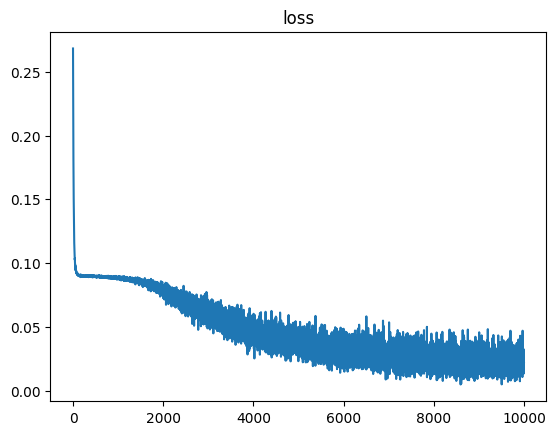

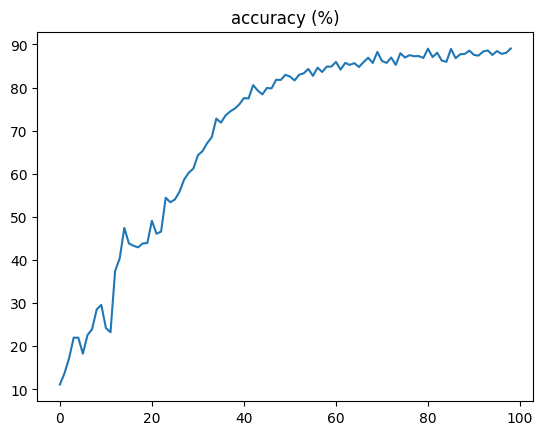

In [144]:

epochs = 10000 #10000
batch_size = 20 #64
input_size = 784
hidden_size = [30]*2
                
tran = Trainer(epochs,batch_size,input_size,hidden_size)

# Tests

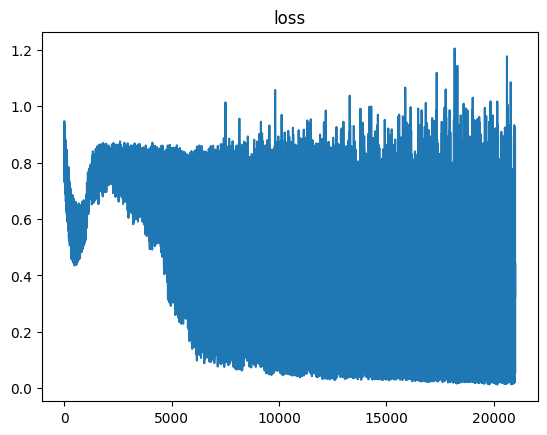

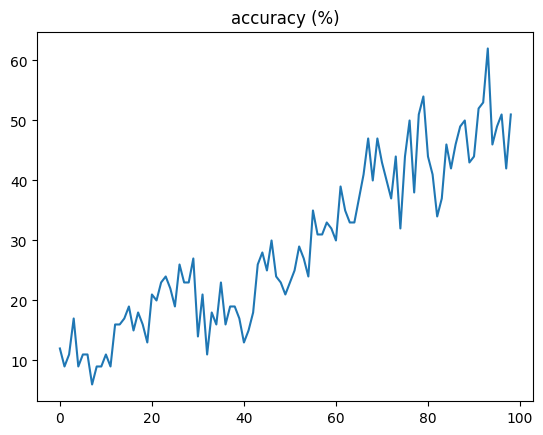

In [55]:
data=loader.get_train_data()
model=NeuralNetwork(784, [30, 30], 10, "sigmoid")
loss=[]
loops=10000
guess=[]
for i in range(loops//10):
    datapoint=np.random.randint(0, 50000)
    x=data[0][datapoint].reshape((784,1 ))
    y=model.forward(x)
    correct=np.zeros((10, 1));correct[data[1][datapoint]]=1
    guess.append(np.argmax(y._data)==data[1][datapoint])
    L=(y-correct)**2
    loss.append(np.linalg.norm(L._data)) #for plotting
    L.backward()
    L.step(0.001)
for i in range(loops*2):
    datapoint=np.random.randint(0, 50000)
    x=data[0][datapoint].reshape((784,1 ))
    y=model.forward(x)
    correct=np.zeros((10, 1));correct[data[1][datapoint]]=1
    guess.append(np.argmax(y._data)==data[1][datapoint])
    L=(y-correct)**2
    loss.append(np.linalg.norm(L._data)) #for plotting
    L.backward()
    L.step(0.01)
plt.plot([i for i in range(len(loss))], loss)
plt.title("loss")
plt.show()
acc=[]
for i in range(0, loops-100, 100):
    acc.append(np.sum(guess[i:i+100]))
plt.plot([i for i in range(len(acc))], acc)
plt.title("accuracy (%)")
plt.show()
    


In [6]:
input_size, hidden_size, output_size = 784, 30, 10
B = 16  # batch size
def sigmoid(x):
    return 1/(1+np.exp(-x))
nn = NeuralNetwork(784, [30], 10, sigmoid)  # ← مقیاس خارج از منابع
print(type(nn.forward(np.random.rand(784, 1))))
print(nn.forward(np.random.rand(784, 10))) #seems to work



<class '__main__.Data'>
[[0.44727163 0.47931648 0.71711655 0.63696551 0.44374704 0.57755508
  0.46987983 0.57823395 0.4800677  0.60014184]
 [0.39163633 0.24379843 0.33507117 0.23058644 0.39805925 0.31640789
  0.28519559 0.33744971 0.25407806 0.20576311]
 [0.38266694 0.50791423 0.48136195 0.36298826 0.27025899 0.66580478
  0.36331519 0.44016546 0.45898995 0.16852029]
 [0.7169418  0.78572874 0.79101364 0.67755803 0.72253982 0.69704363
  0.6421497  0.72676161 0.71674824 0.69840373]
 [0.49464986 0.54988037 0.47604741 0.47680603 0.46685034 0.58616986
  0.38737874 0.28176538 0.53509634 0.34329737]
 [0.71767544 0.61472678 0.41807013 0.58948044 0.68277166 0.49177431
  0.61828517 0.64151722 0.56684625 0.55957111]
 [0.45472653 0.66064389 0.51889394 0.70136849 0.59649424 0.57822879
  0.59019913 0.41241222 0.66573789 0.47394497]
 [0.67116206 0.71479633 0.62323293 0.78310236 0.67261103 0.70758342
  0.62155148 0.60807877 0.64168582 0.7034549 ]
 [0.69038631 0.64465621 0.64116626 0.62249889 0.57412164

In [ ]:
class attacker:
    def __init__(self, model: NeuralNetwork, epsilon: float = 0.1):
        self.model = model
        self.epsilon = epsilon

    def fgsm(self, x: np.ndarray, y: np.ndarray):
        """Fast Gradient Sign Method (FGSM) attack.
        
        Args:
            x: Input data (input_size, batch_size)
            y: True labels (output_size, batch_size)
        
        Returns:
            Adversarial examples (input_size, batch_size)
        """
        # Forward pass
        x_adv = x.copy()
        x_adv.requires_grad = True
        y_pred = self.model.forward(x_adv)

        # Compute loss (assuming cross-entropy loss)
        loss = self.cross_entropy_loss(y_pred, y)

        # Backward pass
        loss.backward()

        # Generate adversarial examples
        x_adv = x_adv + self.epsilon * np.sign(x_adv.grad)
        x_adv = np.clip(x_adv, 0, 1)
        return x_adv
    
    def cross_entropy_loss(self, y_pred: np.ndarray, y_true: np.ndarray):
        """Compute cross-entropy loss.
        
        Args:
            y_pred: Predicted probabilities (output_size, batch_size)
            y_true: True labels (output_size, batch_size)
        
        Returns:
            Loss value
        """
        m = y_true.shape[1]
        p = self.softmax(y_pred)
        log_likelihood = -np.log(p[y_true, range(m)])
        loss = np.sum(log_likelihood) / m
        return loss
    
    def softmax(self, z: np.ndarray):
        """Compute softmax function.
        
        Args:
            z: Input array (output_size, batch_size)
        
        Returns:
            Softmax probabilities (output_size, batch_size)
        """
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / exp_z.sum(axis=0, keepdims=True)
    
# Example usage:
# attacker_instance = attacker(nn, epsilon=0.1) 
# x_adv = attacker_instance.fgsm(x, y)

    